In [1]:
root_folder = '/media/DATA/jbonato/astro_segm'

In [2]:
import numpy as np
import numpy.ma as ma
import os
import h5py
from skimage import io
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import math
import time
import sys
import pickle
from visdom import Visdom

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from collections import defaultdict
from sklearn.metrics import f1_score
import cv2
import pandas as pd
import h5py

from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
############### Visualization

from ipywidgets import Button, Layout
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display,clear_output,Video
from copy import copy
import numpy.ma as ma
import matplotlib.colors as colors
import imageio


sys.path.insert(0,root_folder+'/RASTA/modules/')
from gen_single_astro  import filt_im
from sel_active_reg_gen import *
from model.dense_up import dense_up

from test_fun import gen_sc_mask,fix_mask,prob_calc,small_soma_to_proc,common_merge_par,art_rem_large,art_rem

from get_traces import update_dict_DNN
from gui_results import layout
from mask_roi_from_fiji import create_mask

# model to import
model = dense_up(3)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device1 = torch.device('cpu')#('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


###
MAX_ROI_AREA_PROC=30
MU_PX = 1
DOMAIN_RADIUS = 60
# motion corr in extracting traces
motion_corr=True

In [3]:
#!apt update && apt install -y libsm6 libxext6

In [4]:
#!apt-get install -y libxrender-dev

In [5]:
#PARAMS
N=512
M=512

fov_list =[2]
fov_DNN_weights_folder = root_folder+'/weights/dense_up' 
set_dir=root_folder+'/set4/'

In [6]:
class SimDataset_test(Dataset):
    def __init__(self,image_set):
        self.input_images = image_set    


    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):        
        image = self.input_images[idx]
        image = torch.from_numpy(image).float()

        return image

    
vis_flag = False
##### LOAD PARAM DICT
with open(set_dir+'.tmp/dict_dataset.txt', "rb") as fp:   #Pickling
    dict_param = pickle.load(fp)

dict_param
dict_param['init_th_'] = 0.5

In [7]:
# dict_param['blocks']=17*2
# dict_param['threads']=24
# dict_param['BPM_ratio']=2

# dict_param['N_pix_st']=50
# dict_param['astr_min']=45

# dict_param['th1_p']=.2
# dict_param['th2_p']=.05

dict_param['max_min']=np.asarray([345,45])

# dict_param['astro_num']=90
# dict_param['bb']=48
# dict_param['pad']=0
# dict_param['list']=[i*29 for i in range(17)]
# dict_param['decr_dim'] = 5
# dict_param['init_th_'] = 0.5

# # dict_param['corr_int'] =16  
max_min = dict_param['max_min']
# dict_param

In [8]:
# stack_dir = set_dir+'/4/TOMATO_14_Ch1__concatenate_corrected_aligned'
# stack = io.imread(stack_dir + '.tiff').astype(np.uint16)[:750,:,:]
# print(stack.shape)
# stack[:,220:,0:60]=0

# io.imsave(stack_dir + 'SupplementalMovie1_filt.tiff',stack)


In [9]:
# # # stack.shape
# for i in range(30,70):
#     print(i,442/i)

In [10]:
# len(dict_param['list'])

In [11]:
# for i in range(30):
#     print(32*i)

In [12]:
# # stack.shape
# for i in range(20,40):
#     print(i,464/i)

In [13]:
# plt.figure(figsize=(10,10))
# plt.imshow(np.median(stack,axis=0))

In [14]:
# import numpy as np
# from skimage import io
# import matplotlib.pyplot as plt
# import cv2
# from sklearn.externals.joblib import Parallel, delayed
# from skimage.restoration import denoise_nl_means,estimate_sigma
# from scipy import signal
# from joblib import Parallel, delayed
# import os
# import h5py
# from numba import cuda,float32,uint16,float64  

# class ThScal():
#     def __init__(self,stack):
#         kernel = np.ones((50,50),np.float32)/(50*50)
#         density = cv2.filter2D(np.median(stack,axis=0),-1,kernel)
#         self.density = density/np.amax(density)
        
#     def ThMat(self,ff,th_):
#         N,M = ff.shape
#         mask_th = th_*np.ones((N,M))
        
#         cnt=1
#         for i in [0.6,0.4,0.2,0]:
#             buff = self.density.copy()
#             buff[buff<i]=0
#             buff[buff>=i+0.2]=0
#             buff[buff>0]=1
#             mask_th-=buff*(th_*0.05*cnt)
#             cnt+=1

#         ff[ff<mask_th]=0
#         ff[ff>0]=1
#         return ff

# # @cuda.jit

# # (bz,blocks_to_load[stps],mat_per_g,stack_gpu,im_out_g,cover_g,self.BPM_ratio,self.stp,self.iter_block)

# # def sel_active_gpu(T,per_mat,stack,im_out,cover,BPM_ratio,stp,iter_block):
# #     b_dimx = cuda.blockDim.x
# #     b_dimy = cuda.blockDim.y
    
# #     bx = cuda.blockIdx.x  
# #     by = cuda.blockIdx.y
            
# #     tx = cuda.threadIdx.x
# #     ty = cuda.threadIdx.y

# #     for bz in range(T):
# #         if stack[bz,(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty] >= per_mat[bz,bx//BPM_ratio,by//BPM_ratio]:
# #             cuda.atomic.add(im_out,(bz,(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)
   
# #         cuda.atomic.add(cover,(bz,(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)

# @cuda.jit
# def sel_active_gpu_gen(bz,time_ref,per_mat,stack,im_out,cover,BPM_ratio,stp,iter_block,last_stp):
#     #clean code 32 with step 5 with cycle 928 with step*cycle*iter-step
    
#     size = cuda.gridDim.x
#     iterat = iter_block//(size//BPM_ratio)
#     if iter_block%(size//BPM_ratio)>0:
#         iterat+=1
    
    
    
#     b_dimx = cuda.blockDim.x
#     b_dimy = cuda.blockDim.y
#     stp_iter = b_dimx*(size//BPM_ratio)
    
#     bx = cuda.blockIdx.x  
#     by = cuda.blockIdx.y
            
#     tx = cuda.threadIdx.x
#     ty = cuda.threadIdx.y

#     for it_bk in range(iterat):
#         for it_bk_y in range(iterat):
        
#             if it_bk*stp_iter+((bx//BPM_ratio)*stp)<=last_stp and it_bk_y*stp_iter+((by//BPM_ratio)*stp)<=last_stp:

#                 if stack[bz,it_bk*stp_iter+(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,it_bk_y*stp_iter+(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty] >= per_mat[bz+time_ref,it_bk*5+bx//BPM_ratio,it_bk_y*5+by//BPM_ratio]:
#                     cuda.atomic.add(im_out,(it_bk*stp_iter+(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,it_bk_y*stp_iter+(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)

#                 if bz ==0 and time_ref==0:
#                     cuda.atomic.add(cover,(it_bk*stp_iter+(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,it_bk_y*stp_iter+(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)

# class sel_active_reg():
    
#     def __init__(self,stack,dict_params,verbose=True,static=False):
#         self.stack = stack
#         self.step_list = dict_params['list']
#         if len(self.step_list)==1:
#             self.stp=1
#         else:
#             self.stp = self.step_list[1]-self.step_list[0]
#         self.blocks = dict_params['blocks']
#         self.threads = dict_params['threads']
#         self.BPM_ratio = dict_params['BPM_ratio'] # # of block inside a patch
#         self.bb = dict_params['bb']

#         self.N_pix_st = dict_params['N_pix_st']
#         self.astr_min = dict_params['astr_min']
#         self.per_tile = dict_params['percentile']
#         self.astro_num = dict_params['astro_num']
#         self.init_th_ = dict_params['init_th']
#         self.decr_dim = dict_params['decr_dim']
#         self.decr_th = dict_params['decr_th']
#         self.corr_int = dict_params['corr_int']
#         self.gpu_flag = dict_params['gpu_flag']
#         self.static = static
#         self.verbose = verbose
#         self.iter_block = len(dict_params['list'])
#         self.gpu_num = 0
        
#     @staticmethod
#     def percent_matrix_par(stack,t,listx,bb,per_tile):
#         listy = listx
#         dim = len(listx)
#         matrix= t*np.ones((dim+1,dim),dtype=np.float32)

#         for i in range(dim):
#             for j in range(dim):

#                 x = listx[i] 
#                 y = listy[j]
#                 matrix[i,j] = np.percentile(stack[t,x:x+bb,y:y+bb],per_tile)  

#         return matrix.astype(np.float32) 

#     def sel_active_cpu(self):

#         T,N,M = self.stack.shape
#         T,N,M = stack.shape

#         percent_list = Parallel(n_jobs=10,verbose=0)(delayed(self.percent_matrix_par) (self.stack,i,self.step_list,self.bb,self.per_tile) for i in range(T))
#         percentiles = np.asarray(percent_list)
#         mat_per = percentiles[:,:-1,:]
#         mat_per = mat_per[percentiles[:,-1,0].astype(np.int32),:,:]

#         im_out = np.empty((T,N,M)) 
#         cover = np.zeros((T,N,M)) 
#         for i in range(T):
#             for x in self.listx:
#                 for y in self.listy:

#                     buffer_im = self.stack[i,x:x+self.bb,y:y+self.bb]-mat_per[i,x//self.stp,y//self.stp]
#                     buffer_im[buffer_im<0]=0.
#                     buffer_im[buffer_im>0]=1.

#                     im_out[i,x:x+self.bb,y:y+self.bb]+=buffer_im
#                     cover[i,x:x+self.bb,y:y+self.bb]+=1


        
#         self.mask_tot = np.empty_like(im_out)
#         self.mask_tot  = im_out/cover 
    
#     def sel_active_reg_gpu(self):

#         T,N,M = self.stack.shape
#         cuda.select_device(self.gpu_num)    

#         threadsperblock = (self.threads,self.threads)
#         blockspergrid = (self.blocks,self.blocks)
            
#         if self.verbose: print('Computing local thresholds')
#         # compute percentile in patches
#         if not(self.static):
#             percent_list = Parallel(n_jobs=-1,verbose=1)(delayed(self.percent_matrix_par) (self.stack,i,self.step_list,self.bb,self.per_tile) for i in range(T))
#             percentiles = np.asarray(percent_list).astype(np.float32)
#             mat_per = percentiles[:,:-1,:]

#             mat_per = mat_per[percentiles[:,-1,0].astype(np.int32),:,:]# reorder the embarasing parallel collection of mat
            
#         #### mod for static fluorophore
#         # compute a single percentile for all the stack, and than generate a T x num_patch x num_patch 
#         elif self.static:
#             mat_per = np.percentile(self.stack.flatten(),self.per_tile).reshape(1,1)
#             mat_per = np.tile(mat_per,(T,1,1))
            
            
#         #mat_per = np.zeros((T,len(self.step_list),len(self.step_list)))#,dtype=np.int32   
#         ### allocate percentile matrix
#         if self.verbose: print('GPU started',blockspergrid, threadsperblock,self.iter_block/(self.blocks/self.BPM_ratio),self.step_list[-1])
        
#         mat_per_g = cuda.to_device(mat_per) 
#         ### allocate in ram
#         im_out = np.zeros((N,M),dtype=np.int32)
#         cover = np.zeros((N,M),dtype=np.int32)
#         ### allocate and load in DRAM
#         im_out_g = cuda.to_device(im_out)
#         cover_g = cuda.to_device(cover)
#         #iter_block_gpu = cuda.to_device(self.iter_block)
#         blocks_to_load =[i*1000 for i in range((T//1000)+1)]
#         blocks_to_load.append(T)
       
#         for stps in range(len(blocks_to_load)-1):
#             stack_gpu = cuda.to_device(self.stack[blocks_to_load[stps]:blocks_to_load[stps+1],:,:])
#             print(stps)
            
#             for bz in range(blocks_to_load[stps+1]-blocks_to_load[stps]):
#                 sel_active_gpu[blockspergrid, threadsperblock](bz,blocks_to_load[stps],mat_per_g,stack_gpu,im_out_g,cover_g,self.BPM_ratio,self.stp,self.iter_block,self.step_list[-1])
                
#             ### free from old stack
#             del stack_gpu

#         im_out = im_out_g.copy_to_host()
#         cover = cover_g.copy_to_host()
#         if self.verbose: print('GPU done')
#         del im_out_g, cover_g, mat_per_g
        
#         self.mask_tot = np.empty_like(im_out).astype(np.float64)
#         self.mask_tot  = im_out.astype(np.float64)/cover.astype(np.float64) 
#         return im_out,cover 
          
#     def get_mask(self,find_round=True):
#         T,_,_ = self.stack.shape
        
#         if self.gpu_flag:
#             self.sel_active_reg_gpu()
#         else:
#             self.sel_active_reg_cpu()
    
#         if self.corr_int:
#             print('correcting for non uniform illumination')
#             scaling = ThScal(self.stack)

       
#         th_ =round(T*self.init_th_)
        
#         if find_round:
#             #this is an alternative strategy to select the strating point threshold the nearest to th_, it is a seed for the while below 
#             #this strategy can be removed and th_ will be the T*self.init_th_ and not one of the seed points below
#             # we used this strategy for dataset-1, this approach reduces large variation in th_ due to small variation in self.init_th_
#             if T>500: 
#                 th_list = [200,250,300,350,400,450,500,550,600,650,700]
#                 th_list = (T/750)*np.asarray(th_list)
#                 th_ref =th_list-th_
#                 th_ = th_list[np.argmin(np.abs(th_ref))]
#         cnt=0
#         #print(th_)
#         starting_th = th_
#         flag_th=True
#         N_pix = self.N_pix_st
        
#         while(cnt<self.astro_num and N_pix>=self.N_pix_st*0.3 and th_>round(T*0.3)):
#             if flag_th:
#                 mask_tot_s = self.mask_tot.copy()#np.sum(self.mask_tot,axis=0)

#                 if self.corr_int:
#                     mask_tot_s = scaling.ThMat(mask_tot_s,th_)
#                     mask_tot_s= np.uint8(mask_tot_s)
#                 else:
#                     mask_tot_s[mask_tot_s<=th_]=0
#                     mask_tot_s[mask_tot_s>0.5]=255
#                     mask_tot_s= np.uint8(mask_tot_s)  


#                 ret, labels_r = cv2.connectedComponents(mask_tot_s)
#                 flag_th = False

#             labels = labels_r.copy()
#             cnt=0
#             for i in range(1, ret):
#                 pts =  np.where(labels == i)    

#                 if len(pts[0]) < N_pix:

#                     labels[pts] = 0
#                 else:
#                     cnt+=1

#                     labels[pts] = 255         

#             N_pix-=self.decr_dim
#             if N_pix<=self.astr_min and (starting_th-th_)<105:

#                 th_-=self.decr_th
#                 flag_th = True  
#                 N_pix=self.N_pix_st


#         if self.verbose:
#             print('Zones',cnt)
#         # clean eventual artifacts
#         ret, labels = cv2.connectedComponents(np.uint8(labels))
#         for i in range(1, ret):
#             pts =  np.where(labels == i)    
#             if len(pts[0])<self.astr_min//4:
#                 labels[pts]=0
#         labels[labels>0]=1
#         return labels

In [15]:
def wat(pt,thresh):
    N,M = thresh.shape
    out = np.zeros((N,M,))
    mask_buff = np.zeros_like(thresh)
    mask_buff[pt]=255
    kernel=cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    for it in [1,2,3]:
        mask_buff_er = cv2.erode(np.uint8(mask_buff),kernel,iterations = it)
        ret1, labels2 = cv2.connectedComponents(mask_buff_er)
        if ret1>=3:
            print(it)
            # compute the exact Euclidean distance from every binary
            # pixel to the nearest zero pixel, then find peaks in this
            # distance map
            D = ndimage.distance_transform_edt(mask_buff)
            localMax = peak_local_max(D, indices=False, min_distance=3,labels=mask_buff)
            # perform a connected component analysis on the local peaks,
            # using 8-connectivity, then appy the Watershed algorithm
            markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
            labels = watershed(-D, markers, mask=mask_buff)

            print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
            A,B = np.unique(labels,return_counts=True)
            print(A,B)
            if B.shape[0]>1:
                index = np.argmax(B[1:])
                print('index',A[index+1])
                # loop over the unique labels returned by the Watershed
                # algorithm


                for label in np.unique(labels):
                    if label == 0:
                        continue
                    elif label ==A[index+1]:
                        continue
                    else:
                        out[labels == label]+=1
    out[out>1]=1
    return out


def small_soma_to_proc(soma_mask,N,dilation=True,watershed=True):
    mask_tot = soma_mask.copy()
    if dilation:
        kernel=cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))

        mask_tot = cv2.dilate(np.uint8(mask_tot),kernel,iterations = 1)
        kernel2=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
        mask_tot = cv2.morphologyEx(np.uint8(mask_tot), cv2.MORPH_CLOSE, kernel)    
    
    
    mask_tot[mask_tot>0.5]=255
    mask_tot[mask_tot<=0.5]=0
    mask_tot= np.uint8(mask_tot)
    ret, labels = cv2.connectedComponents(mask_tot)
    labels = labels*soma_mask
    proc_add =np.zeros_like(labels)
    for i in range(1, ret+1):
        pts =  np.where(labels == i)

        if len(pts[0]) <= N:
            labels[pts] = 1
        else:
            labels[pts] = 0
            if watershed:
                proc_add+=wat(pts,soma_mask)   
                
    mask_tot=labels
    
    if watershed:
        return mask_tot,proc_add
    else:
        return mask_tot

In [16]:
time_list = []
dict_im = {}
dict_im['Astro_domain_radius'] = DOMAIN_RADIUS
for jj in fov_list:
    print(jj)
    #im_list = []
    Res_1 = np.zeros((N,M,3))

    test_folder_str =str(jj)
    if len(test_folder_str)==1:
        test_folder_str1='00'+test_folder_str
    else:
        test_folder_str1='0'+test_folder_str

    model.load_state_dict(torch.load(fov_DNN_weights_folder+test_folder_str1+'_set4_v2.pt'))
    
    #collect stack to analyze
    stack_dir = set_dir+test_folder_str+'/'

    items_stack = os.listdir(stack_dir)

    print(stack_dir + items_stack[0])
    stack = io.imread(stack_dir + items_stack[0]).astype(np.uint16)
    
    #for _ in range(10):
    #dict_im['t-series_'+test_folder_str1] = stack
    t1=time.time()
    frames,_,_ = stack.shape


    a_reg = sel_active_reg(stack.astype(np.float32),dict_param)
    #A,B = a_reg.sel_active_reg_gpu()

    mask = a_reg.get_mask(long_rec=True)
#     mask = fix_mask(mask) rem for small pixel size

#     #im_list.append([mask,'Active Regions'])
#     dict_im['Active Regions_'+test_folder_str1] = mask

    filter_ = filt_im(stack,mask,dict_param['bb']-2*dict_param['pad'])#stack_dir + items_stack[0]
    _, image_to_plot = filter_.create_img_d4_par()

#     # for other dataset spatia_pp methods can be called from filter_, outputs are stack filtered and spatial map enhanced  
#     #im_list.append([image_to_plot,'Enhanced'])
#     dict_im['Enhanced_'+test_folder_str1] = image_to_plot
    coord_l = filter_.get_instances()

    assert coord_l!=0, 'Check Active region extraction module'


    image_stack = np.empty((len(coord_l),dict_param['bb'],dict_param['bb'])) 

    image_stack,filt_imageL = filter_.save_im_par(pad=0,case=4,im_enh=image_to_plot)#select the padding val 5 is default


    image_set = image_stack[:,0,:,:]
    image_set = image_set[:,np.newaxis,:,:]

    imageL_set = image_to_plot*filt_imageL
    imageL_set-=np.mean(imageL_set)
    imageL_set= imageL_set[np.newaxis,np.newaxis,:,:]



    model.eval()   # Set model to evaluate mode
#     ######################################## Prob Map
    test_datasetL = SimDataset_test(imageL_set)
    test_loader = DataLoader(test_datasetL, batch_size=15, shuffle=False, num_workers=0)

    inputs = next(iter(test_loader))
    inputs = inputs.to(device)
    pred = model(inputs)

    pred_mean = pred.data.cpu().numpy()
    del test_datasetL,test_loader, inputs,pred

    mean = pred_mean[0]
    maxim = np.amax(mean,axis=0)
    mean[mean<maxim]=0

    prob_mapPL,sm_ent = prob_calc(mean[1,:,:],max_min[0],max_min[1])

    #im_list.append([prob_mapPL,'Prob. Map'])
    #dict_im['Prob. Map PL_'+test_folder_str1] = prob_mapPL
    #im_list.append([sm_ent,'Prob. Map'])
    #dict_im['Prob. Map_'+test_folder_str1] = sm_ent
#     ########################################## putative single cell
    test_dataset_S = SimDataset_test(image_set)
    test_loader = DataLoader(test_dataset_S, batch_size=15, shuffle=False, num_workers=0)


    pred_mean=[]
    for inputs in test_loader:
        inputs = inputs.to(device)

        pred = model(inputs)
        pred_mean.append(pred.data.cpu().numpy())
        del inputs,pred

    torch.cuda.empty_cache()

    for j in range(1,len(pred_mean)):
        pred_mean[0]=np.vstack((pred_mean[0],pred_mean[j]))

    prob_map = np.zeros((N,M,2))

    for i in range(len(coord_l)):
        mean= np.zeros((3,dict_param['bb'],dict_param['bb']))
        mean = pred_mean[0][i,:,:,:].copy()

        maxim = np.amax(mean,axis=0)
        mean[mean<maxim]=0
        mean[mean>=maxim]=1

        small_soma = small_soma_to_proc(mean[1,:,:],N = int((2/3)*max_min[1]),watershed=False) ####remove too small somata segmentated
        mean[0,:,:]+=small_soma
        mean[1,:,:]-=small_soma

        coord = coord_l[i]
        if dict_param['pad']>0:
            Res_1[coord[1]:coord[3],coord[0]:coord[2],0] += mean[0,dict_param['pad']:-dict_param['pad'],dict_param['pad']:-dict_param['pad']]
            Res_1[coord[1]:coord[3],coord[0]:coord[2],1] += mean[1,dict_param['pad']:-dict_param['pad'],dict_param['pad']:-dict_param['pad']]
        else:
            Res_1[coord[1]:coord[3],coord[0]:coord[2],0] += mean[0,:,:]
            Res_1[coord[1]:coord[3],coord[0]:coord[2],1] += mean[1,:,:]


    Res_1[:,:,0] -= Res_1[:,:,1]
    Res_1[Res_1<1]=0
    Res_1[Res_1>0]=1

#     ######### can be wrapped

    soma_f = common_merge_par(Res_1[:,:,1],sm_ent)
    Res_1[:,:,1]=soma_f

    #remove possible artifacts
    small_soma,add_proc = small_soma_to_proc(Res_1[:,:,1],int(0.9*max_min[1]),dilation=False,watershed=True)
    Res_1[:,:,1]-=(small_soma+add_proc)
    Res_1[:,:,0]+=add_proc
    
    small_soma = small_soma_to_proc(Res_1[:,:,1],int(0.9*max_min[1]),dilation=False,watershed=False)
    Res_1[:,:,1]-=(small_soma)
    
    
    Res_1[:,:,0] = Res_1[:,:,0]-Res_1[:,:,1]
    Res_1[Res_1<1]=0
    Res_1[Res_1>0]=1

    #remove large region classified as soma Area>500
#     Res_1_filt,removal = art_rem_large(Res_1[:,:,1],Res_1[:,:,0],N=int(1.15*max_min[0]))
#     if removal<2:
#         Res_1-=Res_1_filt[:,:,np.newaxis]

#     Res_1_filt,removal = art_rem_large(Res_1[:,:,1],Res_1[:,:,0],N=max_min[0])
#     if removal<2:
#         Res_1-=Res_1_filt[:,:,np.newaxis]


    #remove processes without soma
    Res_1_filt = art_rem(Res_1[:,:,1],Res_1[:,:,0])
    Res_1*=Res_1_filt[:,:,np.newaxis]

    #dict_im['Final_Mask_'+test_folder_str1] = Res_1
    #print('Time', time.time()-t1)
    #print(20*'%')
    time_list.append(time.time()-t1)

#     with h5py.File('/media/DATA/jbonato/astro_segm/Results/D4/FOV_'+test_folder_str1+'.hdf5','w') as f:
#         dset = f.create_dataset('Values',data=Res_1[:,:,0])
#         dset2 = f.create_dataset('Values_soma',data=Res_1[:,:,1])
#     #######################################################################################################
#     #Visualization of images
#     if vis_flag:
#         vis = Visdom(port=8097, server="http://localhost",env='inference_plot')
#         for key in dict_im.keys():
#             if key in ['Active Regions_'+test_folder_str1,'Enhanced_'+test_folder_str1,'Final_Mask_'+test_folder_str1]:
#                 image = dict_im[key]
#                 fig, ax = plt.subplots(figsize=(4,4))
#                 ax.imshow(image)
#                 ax.axis('off')
#                 ax.set_title(key)
#                 vis.matplot(fig)
#                 plt.close(fig)
    
#     #### Extraction
#     single_astro_roi = gen_sc_mask(dict_im['Final_Mask_'+test_folder_str1])


2
/media/DATA/jbonato/astro_segm/set4/2/TSeries-07012021-0901-798_Ch1__movie_corrected.tiff
GEN
Computing local thresholds


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.8s finished


Iteration per block:  1.0
GPU started with  (34, 34)  blocks and  (24, 24)  threads per block
0
GPU done
Init threshold 150
Zones 130
file already loaded


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    0.4s finished


2
[INFO] 3 unique segments found
[0 1 2 3] [262050     42     21     31]
index 1
2
[INFO] 2 unique segments found
[0 1 2] [262042     81     21]
index 1
2
[INFO] 3 unique segments found
[0 1 2 3] [261976     85     20     63]
index 1
1
[INFO] 3 unique segments found
[0 1 2 3] [261838     72     68    166]
index 3
2
[INFO] 3 unique segments found
[0 1 2 3] [261838     72     68    166]
index 3
3
[INFO] 3 unique segments found
[0 1 2 3] [261838     72     68    166]
index 3
1
[INFO] 4 unique segments found
[0 1 2 3 4] [261896     31     44     60    113]
index 4
2
[INFO] 4 unique segments found
[0 1 2 3 4] [261896     31     44     60    113]
index 4
2
[INFO] 2 unique segments found
[0 1 2] [262053     45     46]
index 2
2
[INFO] 2 unique segments found
[0 1 2] [262037     70     37]
index 1
2
[INFO] 2 unique segments found
[0 1 2] [262023     50     71]
index 2
3
[INFO] 2 unique segments found
[0 1 2] [262023     50     71]
index 2
3
[INFO] 3 unique segments found
[0 1 2 3] [261953     

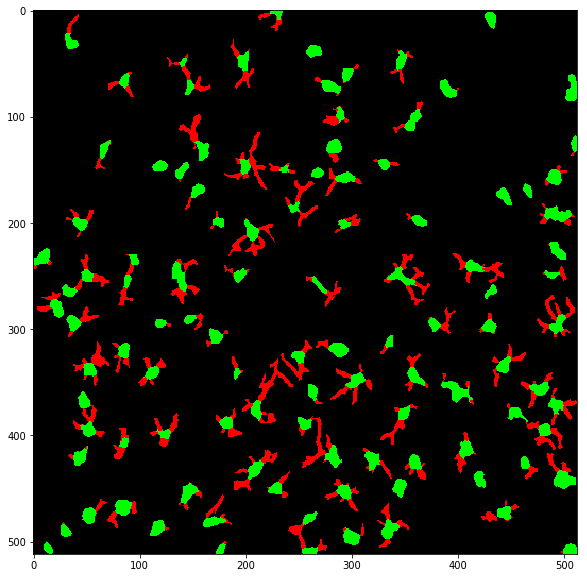

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(Res_1)

[  0   4   5   6   7   8   9  14  15  16  17  18  19  20  21  22  23  24
  25  28  30  32  33  34  35  36  37  38  39  40  41  43  44  45  46  47
  48  49  50  51  52  54  55  57  58  60  61  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  83  84  86  87  89  91  92  93
  94  95  96  97  98  99 100 102 103 106 107 108 109 110 111 112 113 114
 115 116 117 119 120 122 123 124 125 126 127 128 129 130 132 133 134 135
 136 137 139 140 142 143 144 148 149 151 152 153 154 155 157 158 159 160
 161 162 164 165 166 167 168 169 170 173 175 176 177 178 179 181 182 183
 185 186 188 189 193 195 197 198 199 200 201 202 204 207 208 209 210 211
 212 213 214 216 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 237 240 241 242 244 246 247 248 249 250 251 252 253]


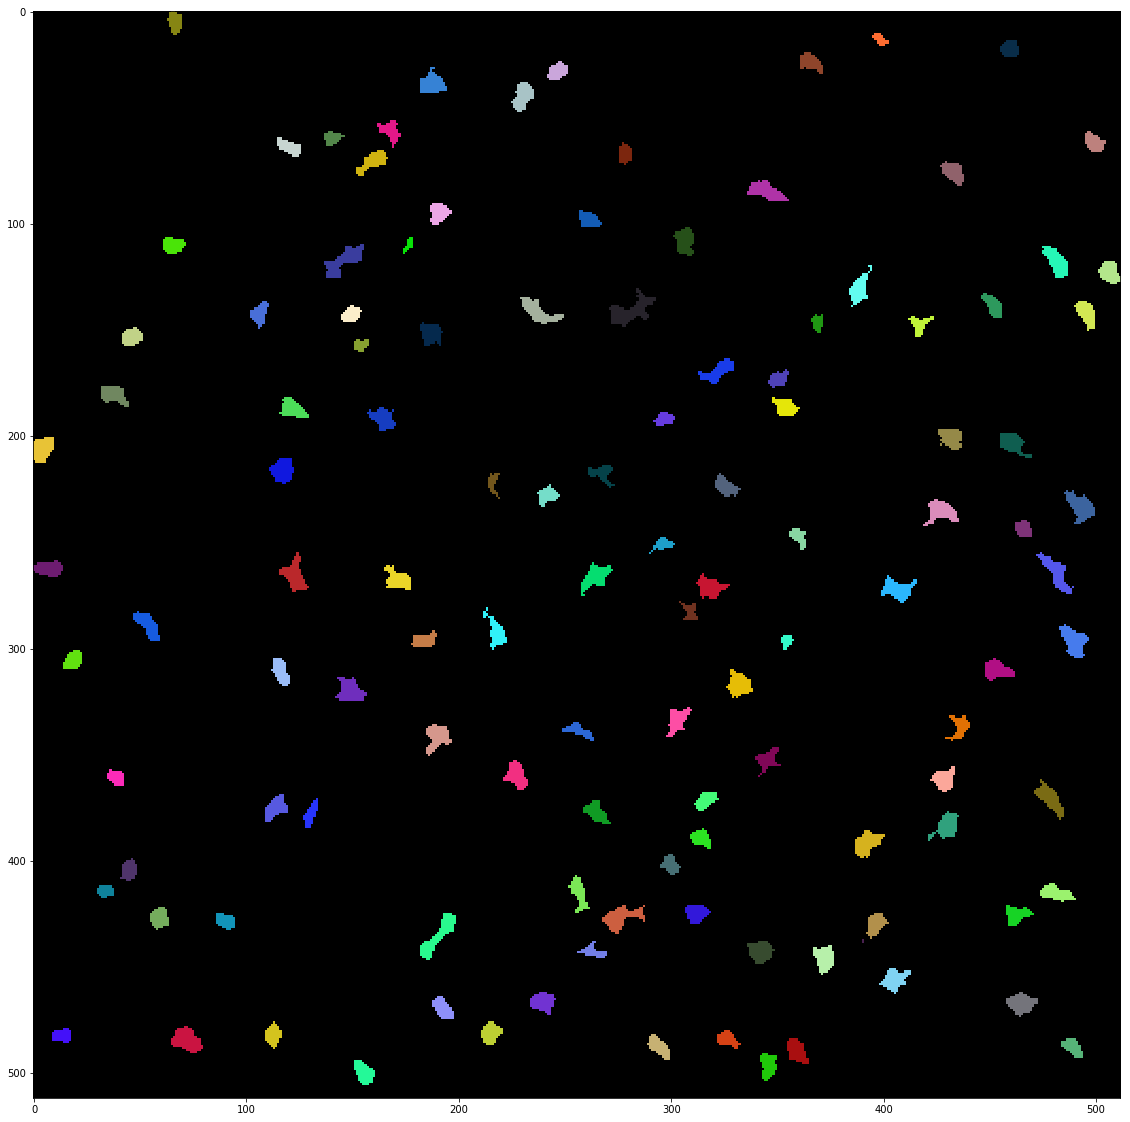

In [65]:
# plt.figure(figsize=(10,10))
# plt.imshow(add_proc)

mask_buff= Res_1[:,:,1]
kernel=cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
mask_buff_er = cv2.erode(np.uint8(mask_buff),kernel,iterations = 1)
ret1, labels2 = cv2.connectedComponents(mask_buff_er)

mask_f = np.zeros((512,512,3),np.uint8)

for i in range(1,labels2.max()):
        a = np.random.randint(1,255,1)
        b = np.random.randint(1,255,1)
        c = np.random.randint(1,255,1)
        
        pts = np.where(labels2==i)

        mask_f[pts[0],pts[1],0] = a[0] 
        mask_f[pts[0],pts[1],1] = b[0] 
        mask_f[pts[0],pts[1],2] = c[0] 
        
plt.figure(figsize=(20,20))
plt.imshow(mask_f)
print(np.unique(mask_f))

[[0. 1. 0.]
 [1. 1. 1.]
 [0. 1. 0.]]
[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  29  30  31  32  33  34  37  38  39  40  41
  43  44  46  48  49  50  51  53  54  55  56  57  59  60  61  62  63  65
  66  68  69  70  71  73  74  75  76  77  79  80  81  82  84  85  86  87
  88  89  91  92  94  95  96  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 142 143 144 145 146
 147 148 149 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 175 176 177 178 180 182 183 184 185 186
 187 188 189 190 192 193 194 197 198 199 200 201 203 204 206 207 208 209
 210 212 213 214 215 216 217 218 219 220 221 222 223 224 225 228 229 230
 231 232 233 234 236 237 238 239 240 241 242 243 244 245 246 247 248 250
 251 252 253 254]


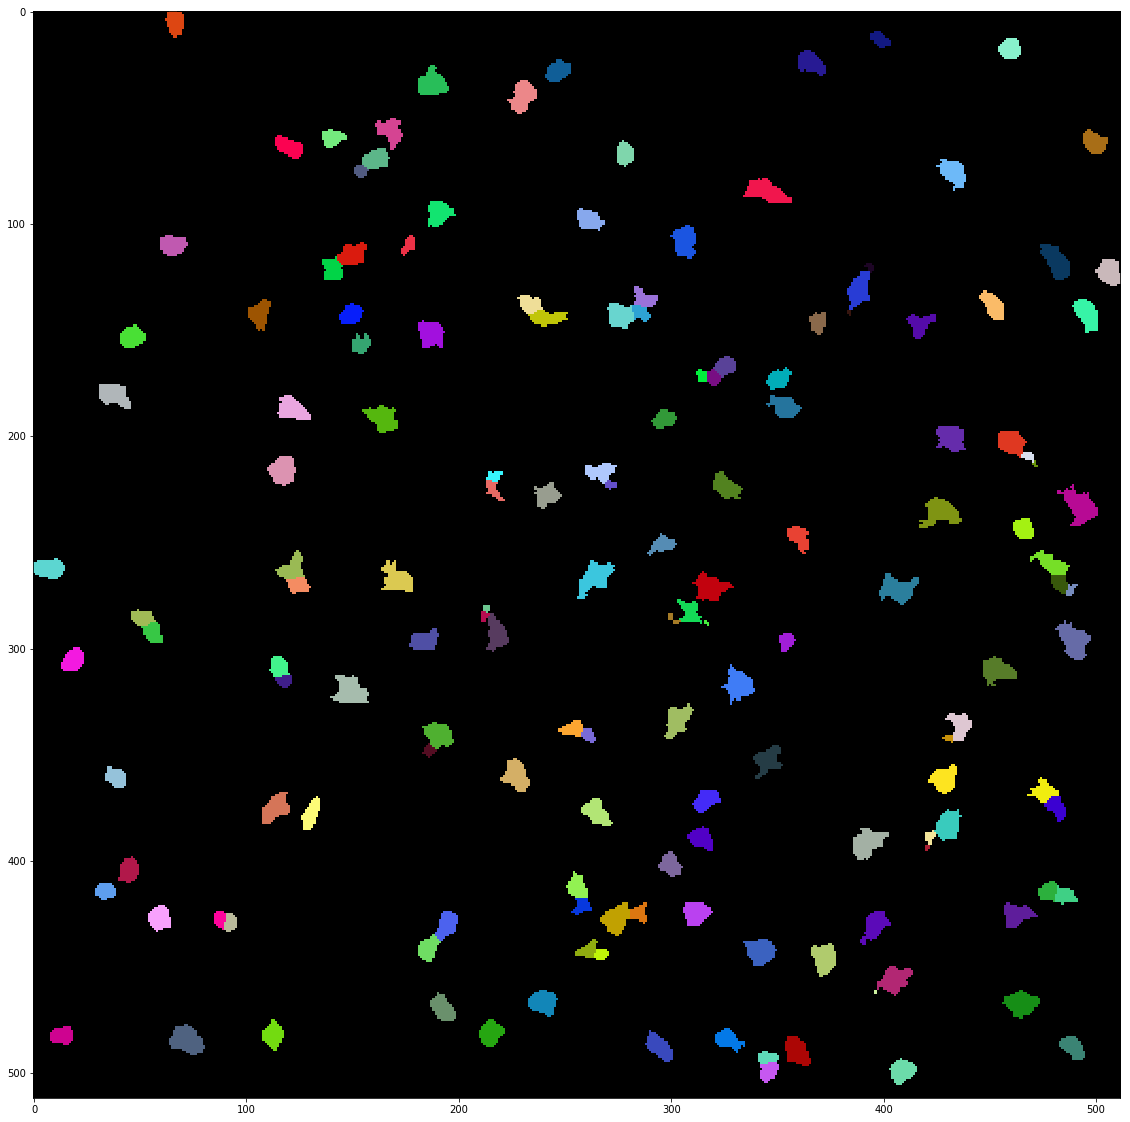

In [61]:
mask_buff = Res_1[:,:,1]
D = ndimage.distance_transform_edt(mask_buff)
localMax = peak_local_max(D, indices=False, min_distance=3,labels=mask_buff)
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
mat = np.ones((3, 3))
mat[0,0]=0
mat[0,2]=0
mat[2,0]=0
mat[2,2]=0
print(mat)
markers = ndimage.label(localMax, structure=np.ones((3,3)))[0]
labels = watershed(-D, markers, mask=mask_buff)

mask_f = np.zeros((512,512,3),np.uint8)

for i in range(1,labels.max()):
        a = np.random.randint(1,255,1)
        b = np.random.randint(1,255,1)
        c = np.random.randint(1,255,1)
        
        pts = np.where(labels==i)

        mask_f[pts[0],pts[1],0] = a[0] 
        mask_f[pts[0],pts[1],1] = b[0] 
        mask_f[pts[0],pts[1],2] = c[0] 

plt.figure(figsize=(20,20))
plt.imshow(mask_f)
print(np.unique(mask_f))

In [42]:
np.unique(labels)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [20]:
a,b = cv2.connectedComponents(Res_1[:,:,1].astype(np.uint8))

for i in range(1,a):
    pts = np.where(b==i)
    print(len(pts[0]))

86
51
86
107
92
140
133
111
70
98
95
77
128
187
161
108
96
136
65
101
197
149
115
151
236
103
173
100
125
85
94
126
98
124
100
139
83
131
125
113
132
76
162
150
126
139
113
139
142
120
182
168
80
97
105
166
183
114
171
165
148
161
99
143
138
174
101
96
92
106
141
172
160
127
111
150
96
119
135
124
77
164
96
127
85
114
157
94
156
85
91
134
64
131
102
191
113
116
83
189
119
82
140
134
140
123
149
108
98
108
167
78
92
115
122
90
111
114
108


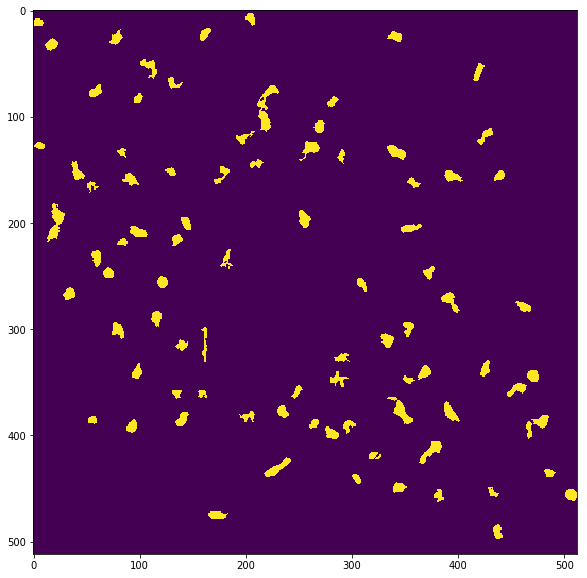

In [84]:
plt.figure(figsize=(10,10))
plt.imshow(sm_ent)
# print(B.min(),B.max())

In [85]:
time_list

[129.4952278137207]

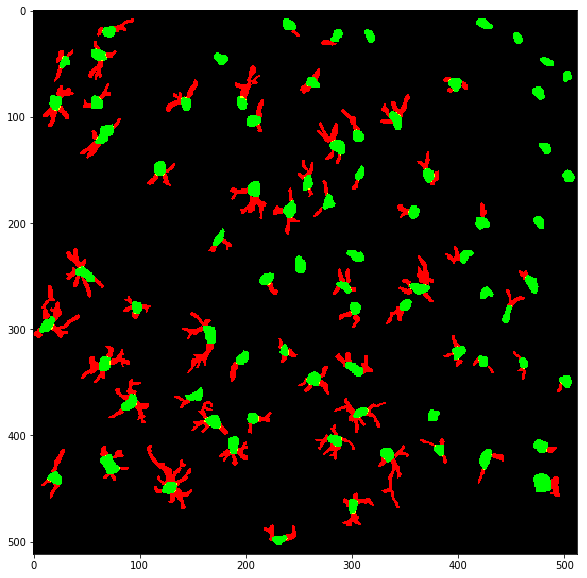

In [86]:
Res_file_path=root_folder+'/set4/dataset/FOV_001_nf.hdf5'
Res_mat = np.zeros((512,512,3))
dset= h5py.File(Res_file_path,'r') 
Res_mat[:,:,0] =  np.asarray(dset['Values'])
Res_mat[:,:,1] =  np.asarray(dset['Values_soma'])
plt.figure(figsize=(10,10))
plt.imshow(Res_mat)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(2*Res_mat+Res_1)

In [ ]:
from sklearn.metrics import f1_score
print(f1_score(Res_mat[:,:,1].flatten(),Res_1[:,:,1].flatten()))
print(f1_score(Res_mat[:,:,0].flatten(),Res_1[:,:,0].flatten()))

In [ ]:
type(root_folder) 

In [ ]:
plt.imshow(dict_im['Active Regions_'+test_folder_str1])

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(dict_im['Enhanced_'+test_folder_str1])

In [ ]:
plt.imshow(dict_im['Final_Mask_'+test_folder_str1])

# Visualization of results

In [5]:
fov_name = []
for j in fov_list:
    j = str(j)
    if len(j)==1:
        j='00'+j
    else:
        j='0'+j
    fov_name.append(j)
fov_name
hbox,button,display_plot = layout(fov_name,dict_im)
display(hbox)
button.on_click(display_plot)

# Manual curation
Export ROIs for ImageJ

In [6]:
from ROI_manual_curation import *

In [7]:
#export ROIs for ImageJ
export_roi(dict_im,fov_list,N=256,M=256,folder_save = '/media/DATA/jbonato/astro_segm/notebook/')

FOV 002


In [8]:
#clean dictionary from ROIs and extracted traces
dict_im = clean_dict(dict_im,fov_list)

In [9]:
#update dict_im with the manual curated
for fov in fov_list:
    folder = f'{str(fov):0>3}'
    mask_ret = read_roi_curated(folder,N=256,M=256,folder_read='/media/DATA/jbonato/astro_segm/notebook/')
    dict_im = update_dict_DNN(dict_im,mask_ret,folder,motion_corr,MAX_ROI_AREA_PROC,MU_PX)
    #### save dict
    pickle.dump(dict_im, open( "inference_ex.pkl", "wb" ) )

NUM ROI 5
ROI NUM 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 0
ROIS 4
SPLIT DONE (256, 256, 10)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 1
ROIS 1
SPLIT DONE (256, 256, 24)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 2
ROIS 4
SPLIT DONE (256, 256, 10)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 3
ROIS 3
SPLIT DONE (256, 256, 11)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 4
ROIS 4
SPLIT DONE (256, 256, 9)
Extraction: done
